# **PHASE 2: ADVANCED SVD**

## Import các thư viện cần thiết

In [10]:
# SVD
import os
import math
import random
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from collections import defaultdict
from random import sample
from sklearn.metrics import mean_absolute_error, mean_squared_error

from surprise import SVD, SVDpp, Dataset, Reader, accuracy

import time
import pickle
import numpy as np
from tqdm.auto import tqdm
from scipy import sparse

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import normalize

import itertools
import gc

## Chuẩn bị dữ liệu

### 1. Config

In [12]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

DATA_DIR = "../data"
Z_THRESHOLD = 0.0
RATING_MIN = 0.5
RATING_MAX = 5.0
TEST_SIZE = 0.10
VAL_SIZE = 0.10
SAMPLE_USER = 72313
TOP_N = 10
SHOW_ROWS = 50
N_FEATURES_FS = 300

### 2. Load data

In [13]:
# Read file csv
ratings = pd.read_csv(f"{DATA_DIR}/ratings.csv")
movies = pd.read_csv(f"{DATA_DIR}/movies.csv")
tags = pd.read_csv(f"{DATA_DIR}/tags.csv")
genome_scores = pd.read_csv(f"{DATA_DIR}/genome-scores.csv")
genome_tags = pd.read_csv(f"{DATA_DIR}/genome-tags.csv")

### 3. Merge data

In [14]:
# Nối bảng 'ratings' với 'movies' để lấy tiêu đề phim
df = pd.merge(ratings, movies, on='movieId')

total_movies  = movies["movieId"].nunique()          # tổng số phim trong bảng movies
rated_movies  = ratings["movieId"].nunique()         # phim đã có ít nhất 1 rating
tagged_movies = tags["movieId"].nunique()            # phim xuất hiện trong bảng tags

print(f"Original dataset : {len(df):,} ratings | "
      f"{df['userId'].nunique():,} users | "
      f"{df['movieId'].nunique():,} movies (after merge)")

print(f"Total movies      : {total_movies:,}")
print(f"Rated movies      : {rated_movies:,}")       
print(f"Movies in tags    : {tagged_movies:,}")
display(df.head())

Original dataset : 25,000,095 ratings | 162,541 users | 59,047 movies (after merge)
Total movies      : 62,423
Rated movies      : 59,047
Movies in tags    : 45,251


,userId,movieId,rating,timestamp,title,genres
0,1,296,5.0,1147880044,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
1,1,306,3.5,1147868817,Three Colors: Red (Trois couleurs: Rouge) (1994),Drama
2,1,307,5.0,1147868828,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama
3,1,665,5.0,1147878820,Underground (1995),Comedy|Drama|War
4,1,899,3.5,1147868510,Singin' in the Rain (1952),Comedy|Musical|Romance


### 4. Encode

In [15]:
user_encoder = LabelEncoder()
user_encoder.fit(df['userId'])
df['user_idx'] = user_encoder.transform(df['userId'])


movie_encoder = LabelEncoder()
movie_encoder.fit(df['movieId'])
df['movie_idx'] = movie_encoder.transform(df['movieId'])

n_users  = df["user_idx"].nunique()
n_items  = df["movie_idx"].nunique()
print(f"Dataset: {len(df):,} ratings | {n_users:,} users | {n_items:,} movies")

Dataset: 25,000,095 ratings | 162,541 users | 59,047 movies


### 5. Split data

In [ ]:
split_dir = os.path.join(DATA_DIR, "splits")
os.makedirs(split_dir, exist_ok=True)

train_path = os.path.join(split_dir, "train.csv")
val_path = os.path.join(split_dir, "val.csv")
test_path = os.path.join(split_dir, "test.csv")

In [ ]:
if os.path.exists(train_path) and os.path.exists(val_path) and os.path.exists(test_path):
    print("Loading cached train/val/test splits...")
    train_df = pd.read_csv(train_path)
    val_df = pd.read_csv(val_path)
    test_df = pd.read_csv(test_path)
    
    train_df['user_idx'] = user_encoder.transform(train_df['userId'])
    val_df['user_idx'] = user_encoder.transform(val_df['userId'])
    test_df['user_idx'] = user_encoder.transform(test_df['userId'])
else:
    print("Splitting train/val/test...")
    def train_val_test_split_func(data_frame, test_size=TEST_SIZE, val_size=VAL_SIZE, col="user_idx", seed=SEED):
        train_val, test = train_test_split(
            data_frame, 
            test_size=test_size, 
            random_state=seed, 
            stratify=data_frame[col]
        )
        train, val = train_test_split(
            train_val, 
            test_size=val_size, 
            random_state=seed, 
            stratify=train_val[col]
        )
        return train.reset_index(drop=True), val.reset_index(drop=True), test.reset_index(drop=True)

    train_df, val_df, test_df = train_val_test_split_func(df)
    
    train_df.to_csv(train_path, index=False)
    val_df.to_csv(val_path, index=False)
    test_df.to_csv(test_path, index=False)

print("Split sizes:", {k: len(v) for k, v in zip(["train", "val", "test"], [train_df, val_df, test_df])})


Dataset: 25,000,095 ratings | 162,541 users | 59,047 movies


## **Thuật toán FunkSVD**

### 1. Cài đặt thuật toán

- **Mục tiêu:** Xấp xỉ ma trận đánh giá thưa $$ R \in \mathbb{R}^{n_{\text{users}} \times n_{\text{items}}} $$ bằng tích của hai ma trận yếu tố ẩn  
  $$ P \in \mathbb{R}^{n_{\text{users}} \times k}, \quad Q \in \mathbb{R}^{n_{\text{items}} \times k}, \quad R \approx PQ^T $$

- **Dự đoán:** Điểm đánh giá dự đoán cho người dùng $ u $ và phim $ i $:

  $$
  \hat{r}_{ui} = \mu + b_u + b_i + P_u \cdot Q_i
  $$

  Trong đó:

  - $\mu $: Trung bình toàn bộ đánh giá (global bias).
  - $ b_u $: Bias của người dùng $u$ (xu hướng đánh giá cao/thấp).
  - $ b_i $: Bias của phim $ i $ (xu hướng được đánh giá cao/thấp).
  - $ P_u \cdot Q_i $: Tích vô hướng của vector yếu tố ẩn (kích thước $ k $).

- **Hàm mất mát:** Tối thiểu hóa sai số bình phương với điều chuẩn riêng cho bias và yếu tố ẩn:

  $
  L = \sum_{(u,i) \in \text{known ratings}} (r_{ui} - \hat{r}_{ui})^2 + \lambda_{bu,bi} \left( \sum_u b_u^2 + \sum_i b_i^2 \right) + \lambda_{pq} \left( \sum_u \| P_u \|^2 + \sum_i \| Q_i \|^2 \right)
  $

  Trong đó:

  - $ (r_{ui} - \hat{r}_{ui})^2 $: Sai số bình phương.
  - $ \lambda_{bu,bi} $: Hệ số điều chuẩn cho bias (`reg_bu_bi`).
  - $ \lambda_{pq} $: Hệ số điều chuẩn cho yếu tố ẩn (`reg_pq`).
  - $ b_u^2, b_i^2, \|P_u\|^2, \|Q_i\|^2 $: Phạt các giá trị lớn để tránh overfitting.

- **Tối ưu hóa:** Sử dụng SGD để cập nhật $ \mu, b_u, b_i, P_u, Q_i $ từng mẫu dữ liệu một cách ngẫu nhiên, với learning rate giảm dần (decay).


In [ ]:
# Hàm df_to_numpy() dùng để chuyển DataFrame sang NumPy
def df_to_numpy(df_):
    arr = df_[["user_idx", "movie_idx", "rating"]].to_numpy()
    return arr[:, 0].astype(np.int32), arr[:, 1].astype(np.int32), arr[:, 2].astype(np.float32)

In [ ]:
class FunkSVD:
    def __init__(
        self,
        n_users: int,               # số người dùng
        n_items: int,               # số phim
        k: int = 50,                # yếu tố ẩn
        lr: float = 0.007,
        reg_bu_bi: float = 0.01,    # Hệ số điều chuẩn cho bias (b_u, b_i).
        reg_pq: float = 0.05,       # Hệ số điều chuẩn cho yếu tố ẩn (P, Q ).
        n_epochs: int = 35,
        seed: int = 42,
        verbose: bool = True,
    ):
        rng = np.random.default_rng(seed)
        # Ma trận yếu tố ẩn người dùng, khởi tạo ngẫu nhiên từ phân phối chuẩn, nhân 0.1 để giá trị nhỏ, kiểu float32.
        self.P  = 0.1 * rng.standard_normal((n_users, k)).astype(np.float32)
        # Ma trận yếu tố ẩn phim
        self.Q  = 0.1 * rng.standard_normal((n_items, k)).astype(np.float32)
        #---> Khởi tạo ngẫu nhiên P, Q với giá trị nhỏ tránh gradient lớn ban đầu.
        
        # Vector bias người dùng (b_u) -> khởi tạo = 0
        self.bu = np.zeros(n_users, dtype=np.float32)
        # Vector bias phim (b_i), khởi tạo = 0
        self.bi = np.zeros(n_items, dtype=np.float32)
        #  Global bias (\mu), khởi tạo = 0 
        self.mu = 0.0

        self.lr0 = self.lr = lr # Lưu tốc độ học ban đầu và hiện tại (sẽ giảm qua epoch)
        self.reg_bu_bi = reg_bu_bi
        self.reg_pq    = reg_pq
        self.n_epochs  = n_epochs
        self.verbose   = verbose
        self.train_rmse, self.val_rmse = [], []

    # ───── Train ─────
    def fit(self, train_df, val_df=None, patience: int = 3):
        u_tr, i_tr, r_tr = df_to_numpy(train_df)
        if val_df is not None:
            u_vl, i_vl, r_vl = df_to_numpy(val_df)

        self.mu = r_tr.mean()
        best_val = np.inf
        no_improve = 0

        for ep in range(1, self.n_epochs + 1):
            idx = np.random.permutation(len(r_tr))
            se = 0.0
            for u, i, r in zip(u_tr[idx], i_tr[idx], r_tr[idx]):
                pred = self.mu + self.bu[u] + self.bi[i] + self.P[u] @ self.Q[i]
                err  = r - pred
                se  += err * err

                # update bias
                self.bu[u] += self.lr * (err - self.reg_bu_bi * self.bu[u])
                self.bi[i] += self.lr * (err - self.reg_bu_bi * self.bi[i])

                # update latent factors
                pu_old = self.P[u].copy()
                self.P[u] += self.lr * (err * self.Q[i] - self.reg_pq * self.P[u])
                self.Q[i] += self.lr * (err * pu_old    - self.reg_pq * self.Q[i])

            rmse_tr = np.sqrt(se / len(r_tr))
            self.train_rmse.append(rmse_tr)

            # Validation
            if val_df is not None:
                preds = self.predict_batch(u_vl, i_vl)
                rmse_vl = np.sqrt(mean_squared_error(r_vl, preds))
                self.val_rmse.append(rmse_vl)

                if self.verbose:
                    print(f"Epoch {ep:02d}/{self.n_epochs} – Train {rmse_tr:.4f} | Val {rmse_vl:.4f}")

                # early-stopping
                if rmse_vl + 1e-4 < best_val:
                    best_val = rmse_vl
                    no_improve = 0
                    self._best_state = (self.P.copy(), self.Q.copy(), self.bu.copy(), self.bi.copy())
                else:
                    no_improve += 1
                    if no_improve >= patience:
                        if self.verbose:
                            print(">>> Early-stopping – restore best epoch.")
                        self.P, self.Q, self.bu, self.bi = self._best_state
                        break
            else:
                if self.verbose:
                    print(f"Epoch {ep:02d}/{self.n_epochs} – Train RMSE: {rmse_tr:.4f}")

            self.lr *= 0.95

        return self

    # ───── Inference ─────
    def predict(self, u_idx: int, i_idx: int) -> float:
        est = (
            self.mu
            + self.bu[u_idx]
            + self.bi[i_idx]                
            + self.P[u_idx] @ self.Q[i_idx]
        )
        return float(np.clip(est, 0.5, 5.0))

    def predict_batch(self, users, items):
        return np.clip(
            self.mu + self.bu[users] + self.bi[items] +
            np.einsum("ij,ij->i", self.P[users], self.Q[items]),
            0.5, 5.0,
        )

    # ───── Save / Load ─────
    def save(self, file_path: str):
        """
        Lưu mô hình ra file .npz. 
        """
        dir_name = os.path.dirname(file_path)
        if dir_name and not os.path.exists(dir_name):
            os.makedirs(dir_name, exist_ok=True)

        np.savez_compressed(
            file_path,
            P=self.P, Q=self.Q,
            bu=self.bu, bi=self.bi,
            mu=self.mu,
            train_rmse=np.array(self.train_rmse),
            val_rmse=np.array(self.val_rmse),
            lr=self.lr, lr0=self.lr0,
            reg_bu_bi=self.reg_bu_bi,
            reg_pq=self.reg_pq,
        )

    def load(self, file_path: str):
        """
        Khôi phục model từ file .npz.
        """
        data = np.load(file_path)
        self.P  = data["P"];  self.Q  = data["Q"]
        self.bu = data["bu"]; self.bi = data["bi"]
        self.mu = float(data["mu"])
        self.train_rmse = list(data["train_rmse"])
        self.val_rmse   = list(data["val_rmse"])
        self.lr  = float(data["lr"]);  self.lr0 = float(data["lr0"])
        self.reg_bu_bi = float(data["reg_bu_bi"])
        self.reg_pq    = float(data["reg_pq"])
        return self

### 2. Xây dựng model bằng hai cách

#### Cách 1. Sử dụng mô hình implement

In [ ]:
model_funksvd_custom = FunkSVD(
    n_users=n_users,
    n_items=n_items,
    k=50,
    lr=0.007,
    reg_bu_bi=0.01,
    reg_pq=0.05,
    n_epochs=35,
)
model_funksvd_custom.fit(train_df, val_df, patience=3)
model_funksvd_custom.save(f"{DATA_DIR}/funksvd_best.npz")   

Epoch 01/35 – Train 0.9029 | Val 0.8770
Epoch 02/35 – Train 0.8686 | Val 0.8676
Epoch 03/35 – Train 0.8608 | Val 0.8630
Epoch 04/35 – Train 0.8548 | Val 0.8576
Epoch 05/35 – Train 0.8475 | Val 0.8511
Epoch 06/35 – Train 0.8403 | Val 0.8457
Epoch 07/35 – Train 0.8347 | Val 0.8419
Epoch 08/35 – Train 0.8300 | Val 0.8385
Epoch 09/35 – Train 0.8259 | Val 0.8353
Epoch 10/35 – Train 0.8219 | Val 0.8324
Epoch 11/35 – Train 0.8181 | Val 0.8297
Epoch 12/35 – Train 0.8144 | Val 0.8270
Epoch 13/35 – Train 0.8109 | Val 0.8244
Epoch 14/35 – Train 0.8075 | Val 0.8222
Epoch 15/35 – Train 0.8043 | Val 0.8201
Epoch 16/35 – Train 0.8014 | Val 0.8181
Epoch 17/35 – Train 0.7986 | Val 0.8163
Epoch 18/35 – Train 0.7960 | Val 0.8146
Epoch 19/35 – Train 0.7936 | Val 0.8131
Epoch 20/35 – Train 0.7913 | Val 0.8117
Epoch 21/35 – Train 0.7892 | Val 0.8104
Epoch 22/35 – Train 0.7872 | Val 0.8093
Epoch 23/35 – Train 0.7854 | Val 0.8082
Epoch 24/35 – Train 0.7837 | Val 0.8072
Epoch 25/35 – Train 0.7821 | Val 0.8063


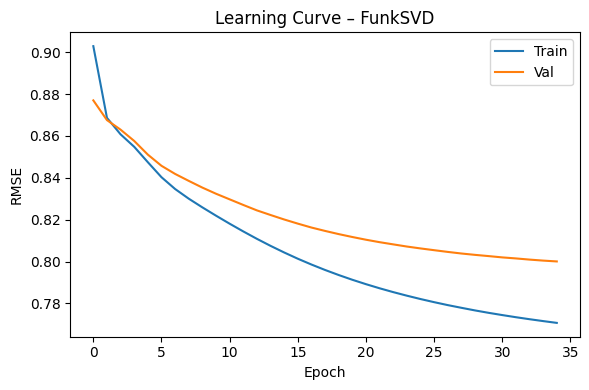

In [ ]:
# learning curve
plt.figure(figsize=(6, 4))
plt.plot(model_funksvd_custom.train_rmse, label="Train")
if model_funksvd_custom.val_rmse:
    plt.plot(model_funksvd_custom.val_rmse, label="Val")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Learning Curve – FunkSVD")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
def evaluate(df_, mdl):
    u, i, r = df_to_numpy(df_)
    pr = mdl.predict_batch(u, i)
    return np.sqrt(mean_squared_error(r, pr)), mean_absolute_error(r, pr)

train_rmse, train_mae = evaluate(train_df, model_funksvd_custom)
val_rmse, val_mae = evaluate(val_df, model_funksvd_custom)
test_rmse, test_mae = evaluate(test_df, model_funksvd_custom)

print(
    f"\nRMSE | MAE\n"
    f"Train: {train_rmse:.4f} | {train_mae:.4f}\n"
    f"Val  : {val_rmse:.4f} | {val_mae:.4f}\n"
    f"Test : {test_rmse:.4f} | {test_mae:.4f}"
)


RMSE | MAE
Train: 0.7691 | 0.5855
Val  : 0.8001 | 0.6073
Test : 0.8005 | 0.6076


#### Cách 2. Sử dụng mô hình từ thư viện Surprise

In [ ]:
class SurpriseFunkSVD:
    def __init__(
        self,
        n_factors=50,
        lr_all=0.007,
        reg_all=0.02,
        n_epochs=20,
        verbose=False,
        rating_scale=(0.5, 5.0)
    ):
        self.model = SVD(n_factors=n_factors, lr_all=lr_all, reg_all=reg_all,
                         n_epochs=n_epochs, verbose=verbose)
        self.rating_scale = rating_scale

    def fit(self, train_df):
        reader = Reader(rating_scale=self.rating_scale)
        data = Dataset.load_from_df(train_df[['user_idx', 'movie_idx', 'rating']], reader)
        trainset = data.build_full_trainset()
        self.model.fit(trainset)
        return self

    def predict(self, u_idx: int, i_idx: int) -> float:
        est = self.model.predict(uid=u_idx, iid=i_idx).est
        return float(np.clip(est, *self.rating_scale))

    def predict_batch(self, users, items):
        preds = []
        for u, i in tqdm(zip(users, items), total=len(users), desc="Predicting"):
            preds.append(self.predict(u, i))
        return np.array(preds)

    def recommend_for_nan(self, df):
        df_nan = df[df["rating"].isna()].copy()
        predictions = self.predict_batch(df_nan["user_idx"].values, df_nan["movie_idx"].values)
        df_nan["predicted_rating"] = predictions
        return df_nan

    def save(self, file_path: str):
        import joblib
        joblib.dump(self.model, file_path)

    def load(self, file_path: str):
        import joblib
        self.model = joblib.load(file_path)
        return self

In [ ]:
model_funksvd = SurpriseFunkSVD(n_factors=50, n_epochs=35)
model_funksvd.fit(train_df) 

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34


In [ ]:
with open(f"{DATA_DIR}/model_funksvd.pkl", 'wb') as f:
    pickle.dump(model_funksvd, f)

In [ ]:
# Dự đoán hàng loạt
preds = model_funksvd.predict_batch(val_df["user_idx"], val_df["movie_idx"])
val_df["predicted_rating"] = preds

Predicting: 100%|██████████| 2000008/2000008 [00:28<00:00, 70853.08it/s] 


In [ ]:
def evaluate(df, model):
    u, i, r = df["user_idx"], df["movie_idx"], df["rating"]
    p = model.predict_batch(u, i)
    return np.sqrt(mean_squared_error(r, p)), mean_absolute_error(r, p)

tr_rmse, tr_mae = evaluate(train_df, model_funksvd)
vl_rmse, vl_mae = evaluate(val_df, model_funksvd)
ts_rmse, ts_mae = evaluate(test_df, model_funksvd)

print(
    f"\nRMSE  | MAE\n"
    f"Train: {tr_rmse:.4f} | {tr_mae:.4f}\n"
    f"Val  : {vl_rmse:.4f} | {vl_mae:.4f}\n"
    f"Test : {ts_rmse:.4f} | {ts_mae:.4f}"
)


Predicting: 100%|██████████| 5000019/5000019 [01:18<00:00, 64042.52it/s] 



RMSE  | MAE
Train: 0.6132 | 0.4646
Val  : 0.7863 | 0.5916
Test : 0.7862 | 0.5916


## **Thuật toán SVD++**

### 1. Cài đặt thuật toán

#### a. Công thức dự đoán rating và ý tưởng

Giả sử $R_{n \times m}$ là ma trận đánh giá gồm $n$ người dùng và $m$ mặt hàng. Mỗi phần tử $r_{ui}$ là đánh giá của người dùng $u$ cho mặt hàng $i$.

Công thức dự đoán rating trong mô hình **SVD++** là:

$$
\hat{r}_{ui} = \mu + b_u + b_i + q_i^T \left(p_u + \frac{1}{\sqrt{|N(u)|}} \sum_{j \in N(u)} y_j \right)
$$

Trong đó:

- $\mu$: trung bình các rating toàn bộ hệ thống  
- $b_u$, $b_i$: độ lệch riêng của người dùng $u$ và movie $i$  
- $p_u$, $q_i$: vector tiềm ẩn đại diện cho người dùng và movie
- $y_j$: vector phản hồi ngầm của movie $j$
- $N(u)$: tập các movie mà người dùng $u$ đã đánh giá

Ý tưởng của SVD++ là kết hợp **cả thông tin explicit (rating)** và **implicit feedback (dạng hành vi như gắn tag, click, xem phim, v.v.)** để cải thiện độ chính xác khi dự đoán.


#### b. Hàm mất mát (Loss function)

Hàm mất mát của mô hình SVD++ được định nghĩa như sau:

$$
\sum_{r_{ui} \in R} \left[ \left(r_{ui} - \mu - b_u - b_i - q_i^T \left(p_u + \frac{1}{\sqrt{|N(u)|}} \sum_{j \in R(u)} y_j \right) \right)^2 + \lambda_1 (b_u^2 + b_i^2) + \lambda_2 ( \|p_u\|^2 + \|q_i\|^2 ) \right]
$$

Giải thích các thành phần:

- Thành phần đầu là **sai số bình phương** giữa rating thực tế và rating dự đoán.

- Các biểu thức chứa $\lambda_1$ và $\lambda_2$ là **regularization**:

  - $\lambda_1$: điều chỉnh độ lệch (bias)

  - $\lambda_2$: điều chỉnh độ lớn của vector tiềm ẩn

Regularization giúp giảm **overfitting**, nhất là khi dữ liệu đánh giá bị **thưa** (sparse). Nó hạn chế mô hình "học thuộc" toàn bộ dữ liệu train và giúp tổng quát hóa tốt hơn trên tập validation.


#### c. Quy tắc cập nhật tham số bằng SGD

Với mỗi mini-batch, chọn ngẫu nhiên các mẫu và cập nhật các tham số $b_u, b_i, p_u, q_i, y_j$ dựa trên sai số $e_{ui} = r_{ui} - \hat{r}_{ui}$ theo các công thức sau:

- $
b_u \leftarrow b_u + \gamma \cdot (e_{ui} - \lambda_1 \cdot b_u)
$

- $
b_i \leftarrow b_i + \gamma \cdot (e_{ui} - \lambda_1 \cdot b_i)
$

- $
q_i \leftarrow q_i + \gamma \cdot \left( e_{ui} \cdot \left( p_u + \frac{1}{\sqrt{|N(u)|}} \sum_{j \in N(u)} y_j \right) - \lambda_2 \cdot q_i \right)
$

- $
p_u \leftarrow p_u + \gamma \cdot (e_{ui} \cdot q_i - \lambda_2 \cdot p_u)
$

- $
\forall j \in N(u): \quad y_j \leftarrow y_j + \gamma \cdot \left( \frac{e_{ui}}{\sqrt{|N(u)|}} \cdot q_i - \lambda_2 \cdot y_j \right)
$

Trong đó:

- $\gamma$: learning rate  
- $\lambda_1, \lambda_2$: hệ số regularization  
- $N(u)$: tập các movie mà user $u$ đã đánh giá  

Mỗi lần cập nhật là một bước tiến nhỏ giúp mô hình tối ưu dần các tham số để giảm sai số dự đoán.


In [ ]:
class SVDppCustom:
    """
    Triển khai mô hình SVD++ cho bài toán hệ thống gợi ý có sử dụng thông tin phản hồi ngầm (implicit feedback).
    """
    def __init__(self, n_users, n_items, 
                 n_factors=20, 
                 lr=0.005, 
                 reg=0.02,
                 reg1=None,
                 reg2=None, 
                 decay=0.95,
                 n_epochs=20):
        """
        Khởi tạo các tham số và ma trận ban đầu của mô hình.

        Args:
            n_users (int): Số lượng người dùng.
            n_items (int): Số lượng sản phẩm (item).
            n_factors (int): Số lượng latent factors.
            lr (float): Learning rate ban đầu.
            reg (float): Hệ số điều chuẩn (regularization).
            reg1 (float): Điều chuẩn cho bias, nếu không có sẽ lấy theo reg.
            reg2 (float): Điều chuẩn cho vector P, Q, Y, nếu không có sẽ lấy theo reg.
            decay (float): Tỷ lệ giảm learning rate sau mỗi epoch.
            n_epochs (int): Số vòng lặp huấn luyện.
        """
        self.n_users = n_users
        self.n_items = n_items 
        self.n_factors = n_factors
        self.lr = lr
        self.reg = reg
        self.reg1 = reg1 if reg1 is not None else reg
        self.reg2 = reg2 if reg2 is not None else reg
        self.decay=decay
        self.n_epochs = n_epochs

        # Khởi tạo bias cho người dùng và item
        self.b_u = np.zeros(n_users)
        self.b_i = np.zeros(n_items)

        # Khởi tạo latent factors cho người dùng (P), item (Q), và phản hồi ngầm (Y)
        self.P = np.random.normal(0, 0.1, (n_users, n_factors))
        self.Q = np.random.normal(0, 0.1, (n_items, n_factors))
        self.Y = np.random.normal(0, 0.1, (n_items, n_factors))

        # Giá trị trung bình toàn bộ dữ liệu
        self.global_mean = 0

    def fit(self, train_data, implicit_feedback, 
            val_data=None,
            early_stopping=True,
            patience=3):
        """
        Huấn luyện mô hình SVD++ trên tập dữ liệu huấn luyện.
        Args:
            train_data (DataFrame): Dữ liệu huấn luyện chứa user_idx, movie_idx và rating.
            implicit_feedback (dict): Phản hồi ngầm - ánh xạ người dùng tới tập các item họ đã tương tác.
            val_data (DataFrame, optional): Tập dữ liệu validation để theo dõi quá trình huấn luyện.
            early_stopping (bool): Có sử dụng early stopping hay không.
            patience (int): Số epoch cho phép mô hình không cải thiện trước khi dừng sớm.
        """
        user_ids = train_data['user_idx'].values
        item_ids = train_data['movie_idx'].values 
        ratings = train_data['rating'].values

        self.global_mean = np.mean(ratings)
        self.Nu = implicit_feedback

        best_val_rmse = float('inf')
        patience_counter = 0

        for epoch in range(self.n_epochs):
            rmse_accum = 0

            for u, i, r_ui in tqdm(zip(user_ids, item_ids, ratings), total=len(ratings), desc=f"Training epoch {epoch+1}", leave=False):
                Nu_u = self.Nu.get(u, set())  # Lấy tập item mà user đã tương tác
                sqrt_Nu = np.sqrt(len(Nu_u)) if Nu_u else 1.0

                # Tính tổng các vector Y của implicit feedback
                y_sum = np.sum(self.Y[list(Nu_u)], axis=0) / sqrt_Nu if Nu_u else 0

                # Dự đoán rating
                pred = self.global_mean + self.b_u[u] + self.b_i[i] + np.dot(self.Q[i], self.P[u] + y_sum)
                err = r_ui - pred
                rmse_accum += err ** 2

                # Cập nhật bias và latent vectors
                self.b_u[u] += self.lr * (err - self.reg1 * self.b_u[u])
                self.b_i[i] += self.lr * (err - self.reg1 * self.b_i[i])
                self.P[u] += self.lr * (err * self.Q[i] - self.reg2 * self.P[u])
                self.Q[i] += self.lr * (err * (self.P[u] + y_sum) - self.reg2 * self.Q[i])

                # Cập nhật latent factors Y cho implicit feedback
                if Nu_u:
                    grad_y = err * self.Q[i] / sqrt_Nu
                    for j in Nu_u:
                        self.Y[j] += self.lr * (grad_y - self.reg2 * self.Y[j])

            train_rmse = np.sqrt(rmse_accum / len(ratings))

            # Đánh giá trên tập validation nếu có
            if val_data is not None:
                val_rmse = self.rmse(val_data)
                print(f"\tEpoch {epoch+1}: Train RMSE = {train_rmse:.5f} | Val RMSE = {val_rmse:.5f}") 

                # Kiểm tra điều kiện dừng sớm
                if val_rmse < best_val_rmse:
                    best_val_rmse = val_rmse  
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if early_stopping and patience_counter >= patience:
                        print(f"Early stopping at epoch {epoch+1}")
                        break
            else:
                print(f"\tEpoch {epoch+1}: Train RMSE = {train_rmse:.5f}")
            
            # Giảm learning rate sau mỗi epoch
            self.lr *= self.decay

    def predict_single(self, u, i):
        """
        Dự đoán rating cho một cặp người dùng - item cụ thể.
        Args:
            u (int): Chỉ số người dùng.
            i (int): Chỉ số item.

        Returns:
            float: Giá trị dự đoán rating, được clip trong khoảng [0.5, 5.0].
        """
        Nu_u = self.Nu.get(u, set())
        sqrt_Nu = np.sqrt(len(Nu_u)) if Nu_u else 1.0
        y_sum = np.sum(self.Y[list(Nu_u)], axis=0) / sqrt_Nu if Nu_u else 0

        pred = self.global_mean + self.b_u[u] + self.b_i[i] + np.dot(self.Q[i], self.P[u] + y_sum)
        return np.clip(pred, 0.5, 5.0)

    def rmse(self, data):
        """
        Tính toán Root Mean Squared Error (RMSE) trên tập dữ liệu.
        Args:
            data (DataFrame): Dữ liệu chứa user_idx, movie_idx và rating.
        """
        user_ids = data['user_idx'].values
        item_ids = data['movie_idx'].values
        ratings = data['rating'].values

        # Dự đoán cho toàn bộ tập dữ liệu
        preds = [self.predict_single(u, i) for u, i in 
                 tqdm(zip(user_ids, item_ids), total=len(data), desc="Evaluating", leave=False)]    
        preds = np.array(preds)
        return np.sqrt(np.mean((ratings - preds) ** 2))

    def mae(self, data):
        """
        Tính toán Mean Absolute Error (MAE) trên tập dữ liệu.
        Args:
            data (DataFrame): Dữ liệu chứa user_idx, movie_idx và rating.
        """
        user_ids = data['user_idx'].values
        item_ids = data['movie_idx'].values
        ratings = data['rating'].values

        # Dự đoán cho toàn bộ tập dữ liệu
        preds = [self.predict_single(u, i) for u, i in 
                 tqdm(zip(user_ids, item_ids), total=len(data), desc="Evaluating", leave=False)]    
        preds = np.array(preds)
        return np.mean(np.abs(ratings - preds))

### 2. Xây dựng model bằng hai cách

#### Cách 1. Sử dụng mô hình implement

##### **1.1. Tạo data train/test/eval**

**Explicit feedback**

- Đảm bảo các movies trong val/test đều đã xuất hiện trong train $\to$ tránh hiện tượng **cold-start for item** khi train model - tức là không đưa những movies mà mô hình chưa từng thấy.

- Trích xuất `[user_idx, movie_idx, rating]` cho từng tập.

In [5]:
# Loại bỏ movieId trong val/test không có trong train -> tránh hiện tượng cold-start for item
train_movie_ids = set(train_df['movieId'])

val_df_pp = val_df[val_df['movieId'].isin(train_movie_ids)].copy()
test_df_pp = test_df[test_df['movieId'].isin(train_movie_ids)].copy()

# Cập nhật lại movie_idx sau khi lọc
val_df_pp['movie_idx'] = movie_encoder.transform(val_df_pp['movieId'])
test_df_pp['movie_idx'] = movie_encoder.transform(test_df_pp['movieId'])

In [6]:
# Tạo dữ liệu train/test/val cho ratings (đã encode)
train_pp = train_df[['user_idx', 'movie_idx', 'rating']]
val_pp = val_df_pp[['user_idx', 'movie_idx', 'rating']]
test_pp = test_df_pp[['user_idx', 'movie_idx', 'rating']]

**Implicit feedback**

Kết hợp 2 nguồn thông tin để tạo implicit_feedback:

- Các movies mà user đã đánh giá (từ ratings).

- Các movies mà user đã gắn tags (từ tags).

**1. Từ ratings**

- Tập `N(u)` được xây dựng cho mỗi user bằng cách lấy toàn bộ các movies mà họ đã đánh giá. Tuy nhiên, nếu dùng toàn bộ tập này (rất lớn), gây rất chậm khi train model $\to$ áp dụng **sampling**

    - Ưu tiên giữ lại các movies phổ biến theo `topk_ratio` (dựa trên tần suất trong tập train).

    - Kết hợp chọn ngẫu nhiên phần còn lại để giữ đa dạng.

- Việc lấy mẫu như vậy giúp cân bằng giữa độ đại diện của các movies quan trọng và độ đa dạng để tránh mô hình bị lệch về các movies phổ biến.

**2. Từ tags**

- Tags phản ánh mức độ tương tác chủ động và mang tính ngữ nghĩa của người dùng với movies. Việc một user tự gắn tag cho một bộ phim cho thấy mức độ chú ý, quan tâm hoặc cảm nhận cá nhân mạnh hơn so với chỉ đơn thuần là đánh giá số sao. Bước làm để tích hợp thông tin này: 

    - Giữ lại những dòng tag mà user và movie đã tồn tại trong train (tránh cold-start)

    - Giới hạn số lượng tag mỗi user (tối đa 20) để kiểm soát độ lớn của tập N(u). Ưu tiên tag theo thời gian gắn (hoặc có thể lấy ngẫu nhiên)

- Các movies từ tags sau đó được thêm vào `N(u)` đã lấy mẫu từ ratings, tạo nên một tập implicit feedback hoàn chỉnh.

In [7]:
# === XỬ LÝ RATINGS ===
# CÁC PHIM NGƯỜI DÙNG ĐÃ RATING (lấy 20 phim phổ biến nhất)

implicit_feedback = defaultdict(set)

# Duyệt qua từng row trong train -> implicit_feedback
for row in train_df.itertuples():
    implicit_feedback[row.user_idx].add(row.movie_idx)

# Đếm số lần mỗi item xuất hiện trong tập train
item_counts = Counter(train_pp['movie_idx'])

def sample_Nu(full_Nu, item_counts, k=20, topk_ratio=0.3):
    """
    Lấy mẫu k item từ tập N(u) = các item user đã tương tác, kết hợp giữa chọn phổ biến và ngẫu nhiên.

    Args:
        full_Nu (set): Tập đầy đủ các item user đã tương tác.
        item_counts (dict): Độ phổ biến (tần suất) của mỗi item trong tập train.
        k (int): Số item cần lấy mẫu.
        topk_ratio (float): Tỷ lệ item được chọn theo độ phổ biến.

    Returns:
        set: Tập k item đã lấy mẫu từ N(u).
    """
    if len(full_Nu) <= k:
        return full_Nu  # Nếu số lượng item < k, trả về toàn bộ

    # Sắp xếp các item theo độ phổ biến giảm dần
    sorted_items = sorted(full_Nu, key=lambda i: -item_counts[i])

    # Xác định số lượng item chọn theo độ phổ biến
    topk = int(k * topk_ratio)
    top_items = sorted_items[:topk]  # Lấy các item phổ biến nhất

    # Lấy phần còn lại bằng cách chọn ngẫu nhiên
    remaining = list(set(full_Nu) - set(top_items))
    rand_items = random.sample(remaining, k - topk)

    # Hợp nhất 2 phần thành tập kết quả
    return set(top_items + rand_items)

# Lấy mẫu implicit feedback cho từng user từ tập N(u) đầy đủ
implicit_feedback_sampled = {
    u: sample_Nu(full_Nu, item_counts, k=20, topk_ratio=0.3)
    for u, full_Nu in implicit_feedback.items()
}

In [8]:
# === XỬ LÝ FILE TAGS ===

# Giữ lại các dòng tag có userId và movieId tồn tại trong encoder (tức là đã xuất hiện trong dữ liệu train)
tags_filtered = tags[
    tags['userId'].isin(user_encoder.classes_) & 
    tags['movieId'].isin(movie_encoder.classes_)
].copy()

# Encode userId và movieId thành chỉ số tương ứng (index) 
tags_filtered['user_idx'] = user_encoder.transform(tags_filtered['userId'])
tags_filtered['movie_idx'] = movie_encoder.transform(tags_filtered['movieId'])

# Giữ tối đa 20 tag cho mỗi user
# Cách 1: Lấy theo thứ tự thời gian — ưu tiên các tag được gắn sớm hơn
tags_filtered = tags_filtered.sort_values('timestamp') 
tags_sampled = tags_filtered.groupby('user_idx').head(20)  

# Cách 2: Có thể thay bằng lấy ngẫu nhiên 20 tag mỗi user 
# tags_sampled = tags_filtered.groupby('user_idx').sample(n=20, replace=False)

# Cách 3. Lọc theo user_idx, lấy movie_idx mà user_idx có tag, không có rating
# rated_pairs = set(zip(train_df['user_idx'], train_df['movie_idx'])) # user_idx và movie_idx đã rating
# # Giữ lại những dòng tag mà (user_idx, movie_idx) chưa từng xuất hiện trong ratings
# tags_no_rating = tags_filtered[~tags_filtered[['user_idx', 'movie_idx']].apply(tuple, axis=1).isin(rated_pairs)]
# # Giữ tối đa 20 tag cho mỗi user
# tags_sampled = tags_no_rating.groupby('user_idx').head(20)


# Cập nhật implicit_feedback_sampled bằng cách thêm các item từ tags
for row in tags_sampled.itertuples():
    implicit_feedback_sampled[row.user_idx].add(row.movie_idx)

In [16]:
# Chọn full =========================

# # RATING
# # Tạo N(u): tập các phim mà user đã tương tác (rating) trong train
# implicit_feedback = defaultdict(set)

# for row in train_df.itertuples():
#     implicit_feedback[row.user_idx].add(row.movie_idx)

# # FILE TAGS
# # Giữ lại user và movie đã có trong encoder
# tags_filtered = tags[
#     tags['userId'].isin(user_encoder.classes_) &
#     tags['movieId'].isin(movie_encoder.classes_)
# ].copy()

# # Bước 2: Mã hóa user và movie
# tags_filtered['user_idx'] = user_encoder.transform(tags_filtered['userId'])
# tags_filtered['movie_idx'] = movie_encoder.transform(tags_filtered['movieId'])

# # Cập nhật thêm vào implicit_feedback từ tags
# for row in tags_filtered.itertuples():
#     implicit_feedback[row.user_idx].add(row.movie_idx)

##### **1.2. Xây dựng mô hình**

In [ ]:
n_users_pp = train_pp['user_idx'].max() + 1
n_items_pp = train_pp['movie_idx'].max() + 1

model_svdpp_cus = SVDppCustom(
    n_users=n_users_pp,
    n_items=n_items_pp,
    n_factors=50,
    lr=0.007,
    reg=0.05,
    reg1=0.01,
    reg2=0.05,
    decay=0.95,
    n_epochs=10
)

model_svdpp_cus.fit(
    train_data=train_pp,
    implicit_feedback=implicit_feedback_sampled,
    val_data=val_pp
)

	Epoch 1: Train RMSE = 0.90252 | Val RMSE = 0.87572


	Epoch 2: Train RMSE = 0.86416 | Val RMSE = 0.85920


	Epoch 3: Train RMSE = 0.84815 | Val RMSE = 0.84821


	Epoch 4: Train RMSE = 0.83789 | Val RMSE = 0.84158


	Epoch 5: Train RMSE = 0.83072 | Val RMSE = 0.83656


	Epoch 6: Train RMSE = 0.82475 | Val RMSE = 0.83232


	Epoch 7: Train RMSE = 0.81948 | Val RMSE = 0.82863


	Epoch 8: Train RMSE = 0.81471 | Val RMSE = 0.82530


	Epoch 9: Train RMSE = 0.81025 | Val RMSE = 0.82222


	Epoch 10: Train RMSE = 0.80605 | Val RMSE = 0.81938


In [ ]:
with open(f"{DATA_DIR}/model_svdpp_cus.pkl", 'wb') as f:
    pickle.dump(model_svdpp_cus, f)

In [ ]:
print(
    f"\nRMSE | MAE\n"
    f"Train: {model_svdpp_cus.rmse(train_pp):.4f} | {model_svdpp_cus.mae(train_pp):.4f}\n"
    f"Val  : {model_svdpp_cus.rmse(val_pp):.4f} | {model_svdpp_cus.mae(val_pp):.4f}\n"
    f"Test : {model_svdpp_cus.rmse(test_pp):.4f} | {model_svdpp_cus.mae(test_pp):.4f}"
)


RMSE | MAE
Train: 0.8008 | 0.6096
Val  : 0.8194 | 0.6230
Test : 0.8198 | 0.6232


#### Cách 2. Sử dụng mô hình từ thư viện Surprise

##### **2.1. Xử lí data train**

In [9]:
# Tạo tập các cặp đã có trong train_df
rated_pairs = set(zip(train_df['user_idx'], train_df['movie_idx']))

# Tính trung bình rating theo user
user_mean_rating = train_df.groupby('user_idx')['rating'].mean().to_dict()

# Danh sách lưu dòng mới
additional_rows = []

for user_idx, movie_idxs in implicit_feedback_sampled.items():
    for movie_idx in movie_idxs:
        if (user_idx, movie_idx) not in rated_pairs:
            avg_rating = user_mean_rating.get(user_idx, 3.0)  # fallback = 3.0 nếu không có
            additional_rows.append({
                'user_idx': user_idx,
                'movie_idx': movie_idx,
                'rating': avg_rating
            })

# Chuyển thành DataFrame
additional_df = pd.DataFrame(additional_rows)

# Nối vào train_df
train_tags_df = pd.concat([train_df, additional_df], ignore_index=True)

print(f"Số lượng tương tác thêm vào từ implicit feedback: {len(additional_df)}")
print(f"Kích thước train_df gốc: {len(train_df)} -> sau khi thêm: {len(train_tags_df)}")

Số lượng tương tác thêm vào từ implicit feedback: 16648
Kích thước train_df gốc: 20250076 -> sau khi thêm: 20266724


In [ ]:
# Định nghĩa Reader
reader = Reader(rating_scale=(0.5, 5))

# Tạo trainset và testset từ DataFrame
trainset = Dataset.load_from_df(train_tags_df[['user_idx', 'movie_idx', 'rating']], reader=reader).build_full_trainset()
valset = list(val_df[['user_idx', 'movie_idx', 'rating']].itertuples(index=False, name=None))
testset = list(test_df[['user_idx', 'movie_idx', 'rating']].itertuples(index=False, name=None))

#### **2.2. Xây dựng mô hình**

In [ ]:
# ======= Khởi tạo và huấn luyện mô hình =======
model_svdpp_sur = SVDpp(n_epochs=30, n_factors=50)
model_svdpp_sur.fit(trainset)

In [ ]:
with open(f"{DATA_DIR}/model_svdpp_sur.pkl", 'wb') as f:
    pickle.dump(model_svdpp_sur, f)

In [ ]:
# ======= Đánh giá trên tập train, validation và test =======
train_predictions = model_svdpp_sur.test(trainset.build_testset()[:10000])
val_predictions = model_svdpp_sur.test(valset)
test_predictions = model_svdpp_sur.test(testset)
print(
    f"\nRMSE | MAE\n"
    f"Train: {accuracy.rmse(train_predictions, verbose=False):.4f} | {accuracy.mae(train_predictions, verbose=False):.4f}\n"
    f"Val  : {accuracy.rmse(val_predictions, verbose=False):.4f} | {accuracy.mae(val_predictions, verbose=False):.4f}\n"
    f"Test : {accuracy.rmse(test_predictions, verbose=False):.4f} | {accuracy.mae(test_predictions, verbose=False):.4f}"
)


RMSE | MAE
Train: 0.6356 | 0.4815
Val  : 0.7783 | 0.5926
Test : 0.7738 | 0.5893


### **Tìm best params cho best model**

In [ ]:
results = []
best_rmse = float('inf')
best_model = None
best_params = None

# Lưới tham số bạn muốn thử
param_grid = {
    'n_factors': [50, 100],
    'lr_all': [0.005, 0.007, 0.01],
    'reg_all': [0.02, 0.1],
    'n_epochs': [20, 30, 50]
}

# Tạo tất cả tổ hợp
param_combinations = list(itertools.product(*param_grid.values()))

for params in param_combinations:
    config = dict(zip(param_grid.keys(), params))
    print(f"Testing params: {config}")

    model = SurpriseFunkSVD(**config, verbose=False)
    model.fit(train_df)

    val_rmse, val_mae = evaluate(val_df, model)

    # Lưu kết quả vào list
    results.append({
        **config,
        "val_rmse": val_rmse,
        "val_mae": val_mae
    })

    # Lưu mô hình tốt nhất
    if val_rmse < best_rmse:
        if best_model:
            del best_model
            gc.collect()
        best_rmse = val_rmse
        best_params = config
        best_model = model
        best_model.save(f"{DATA_DIR}/best_model_funksvd.pkl")
    else:
        del model
        gc.collect()

# Chuyển thành DataFrame và lưu
results_df = pd.DataFrame(results)
results_df.to_csv(f"{DATA_DIR}/gridsearch_funksvd_results.csv", index=False)

print("\nBest Parameters: ", best_params)
print(f"Best Validation RMSE: {best_rmse:.4f}")

In [ ]:
test_rmse, test_mae = evaluate(test_df, best_model)
print(f"Test RMSE: {test_rmse:.4f} | Test MAE: {test_mae:.4f}")

## **Hybrid Model**

### **A. Content-Based**

##### **Sử dụng 2 phương pháp:**

- **Cosine similarity:** Tính độ tương đồng giữa hồ sơ người dùng (dựa trên các phim họ thích) và đặc trưng của phim (genome tags và thể loại) để gợi ý phim tương tự.

- **Ridge Regression:** Học một mô hình tuyến tính cho mỗi người dùng để dự đoán điểm đánh giá dựa trên đặc trưng phim, từ đó gợi ý phim có điểm dự đoán cao.

#### 1. Save/Load 

In [ ]:
PROFILE_CACHE_DIR = "./cache_profiles"
os.makedirs(PROFILE_CACHE_DIR, exist_ok=True)

def save_profiles(profiles_dict, method_name):
    file_path = os.path.join(PROFILE_CACHE_DIR, f"profiles_{method_name}.pkl")
    with open(file_path, "wb") as f:
        pickle.dump(profiles_dict, f)

def load_profiles(method_name):
    file_path = os.path.join(PROFILE_CACHE_DIR, f"profiles_{method_name}.pkl")
    if os.path.exists(file_path):
        with open(file_path, "rb") as f:
            return pickle.load(f)
    return None

In [ ]:
GENOME_CACHE_PATH = os.path.join(PROFILE_CACHE_DIR, "genome_csr_best.pkl") 

def save_genome_csr(csr):  
    with open(GENOME_CACHE_PATH, "wb") as f:
        pickle.dump(csr, f)

def load_genome_csr():  
    if os.path.exists(GENOME_CACHE_PATH):
        with open(GENOME_CACHE_PATH, "rb") as f:
            return pickle.load(f)
    return None

#### 2. Per‑user z‑score (remove bias)

Mỗi người dùng có thang chấm điểm khác nhau. Ví dụ, một người có thể chấm 4/5 là "rất thích", trong khi người khác chấm 4/5 là "bình thường". Chuẩn hóa z-score giúp so sánh đánh giá giữa các người dùng một cách công bằng.

In [ ]:
# Scale rating ở tập train
train_user_stats = train_df.groupby("userId")["rating"].agg(
        ["mean", "std"]).rename(columns={"mean": "mu", "std": "sigma"})

**Z-score:** `z = (x - mu) / sigma`, trong đó `x` là đánh giá, `mu` là trung bình đánh giá của người dùng, `sigma` là độ lệch chuẩn.

- Z-score biểu thị đánh giá lệch bao nhiêu so với trung bình của người dùng, chuẩn hóa về đơn vị độ lệch chuẩn.

- Nếu `sigma=0` (người dùng chỉ chấm một giá trị duy nhất), phép chia sẽ gây lỗi (chia cho 0). Thay bằng 1e-6 để tránh lỗi và giữ z-score hợp lý.

In [ ]:
def add_z_scores(df, user_stats):
    df_with_stats = df.merge(user_stats, on="userId", how="left")

    ratings_mean = train_df["rating"].mean()
    ratings_std = train_df["rating"].std()

    df_with_stats["mu"] = df_with_stats["mu"].fillna(ratings_mean)
    df_with_stats["sigma"] = df_with_stats["sigma"].fillna(ratings_std)
    df_with_stats["rating_z"] = (df_with_stats["rating"] - df_with_stats["mu"]) / df_with_stats["sigma"].replace(0, 1e-6)
    
    return df_with_stats

train_df = add_z_scores(train_df, train_user_stats)
val_df = add_z_scores(val_df, train_user_stats)
test_df = add_z_scores(test_df, train_user_stats)

#### 3. Build genome CSR matrix

In [ ]:
merged_genome = pd.merge(genome_scores, genome_tags, on='tagId', how='left')
genome_matrix = merged_genome.pivot(index='movieId', columns='tag', values='relevance').fillna(0)

#### 4. Genres Vectorization (TF-IDF)

In [ ]:
tfidf = TfidfVectorizer(token_pattern=r'[^|]+')
genres_tfidf = tfidf.fit_transform(movies['genres'])
genres_df = pd.DataFrame(
    genres_tfidf.toarray(), 
    columns=[f'genre:{g}' for g in tfidf.get_feature_names_out()],
    index=movies['movieId']
)

#### 5. Xử lí, gộp ma trận và scale

In [ ]:
all_movies = pd.Index(sorted(set(genome_matrix.index).union(genres_df.index)))

# Phim thiếu genome
missing_genome = all_movies.difference(genome_matrix.index)
if len(missing_genome):
    zero_genome = pd.DataFrame(0, index=missing_genome, columns=genome_matrix.columns)
    genome_matrix = pd.concat([genome_matrix, zero_genome])

# Phim thiếu genres
missing_genre = all_movies.difference(genres_df.index)
if len(missing_genre):
    zero_genre = pd.DataFrame(0, index=missing_genre, columns=genres_df.columns)
    genres_df = pd.concat([genres_df, zero_genre])

In [ ]:
# chỉnh lại index
genome_matrix = genome_matrix.loc[all_movies]
genres_df = genres_df.loc[all_movies]

In [ ]:
# Ghép hai ma trận -> describe_matrix
describe_matrix = pd.concat([genome_matrix, genres_df], axis=1).fillna(0)
print("Describe matrix:", describe_matrix.shape)    

In [ ]:
# Scale lại ma trận cho cùng range
scaler = StandardScaler(with_mean=False)
describe_matrix_scaled = scaler.fit_transform(describe_matrix) 
print(describe_matrix_scaled)

#### 6. Feature Selection

In [ ]:
movie_avg_train = train_df.groupby("movieId")["rating"].mean()

def rating_to_class(rating):
    if rating <= 2.5:
        return 0  # rating thấp
    elif rating <= 4.0:
        return 1  # rating trung bình
    else:
        return 2  # rating cao

train_movies_fs = [m for m in movie_avg_train.index if m in describe_matrix.index]

In [ ]:
X_fs = describe_matrix_scaled[[describe_matrix.index.get_loc(m) for m in train_movies_fs]]
y_fs = movie_avg_train.loc[train_movies_fs].apply(rating_to_class).values
k = min(N_FEATURES_FS, X_fs.shape[1])

# tạo 4 ma trận đặc trưng giám sát
feature_matrices = {}

# 1. Chi-squared
sel_chi = SelectKBest(chi2, k=k).fit(X_fs, y_fs)
feature_matrices["chi2"] = sel_chi.transform(describe_matrix_scaled)

if sparse.issparse(X_fs):        
    X_fs_dense = X_fs.toarray()
else:
    X_fs_dense = X_fs

# 2. Information Gain (Entropy)
tree_e = DecisionTreeClassifier(criterion="entropy", random_state=SEED).fit(X_fs_dense, y_fs)
idx_e = np.argsort(tree_e.feature_importances_)[-k:]
feature_matrices["entropy"] = describe_matrix_scaled[:, idx_e]

# 3. Gini Index
tree_g = DecisionTreeClassifier(criterion="gini", random_state=SEED).fit(X_fs_dense, y_fs)
idx_g = np.argsort(tree_g.feature_importances_)[-k:]
feature_matrices["gini"] = describe_matrix_scaled[:, idx_g]

# 4. Normalized Deviation
std_col = np.std(X_fs_dense, axis=0)
idx_std = np.argsort(std_col)[-k:]
feature_matrices["deviation"] = describe_matrix_scaled[:, idx_std]

#### **Cosine Similarity**

Làm thế nào để biểu diễn sở thích của người dùng?

- Hồ sơ người dùng là một vector tổng hợp các tag genome của những phim họ thích (dựa trên `rating_z ≥ Z_THRESHOLD`). Vector này được tính bằng trung bình có trọng số của các vector phim.

In [ ]:
movieId2row = {mid: i for i, mid in enumerate(describe_matrix.index.values)}
row2movieId = describe_matrix.index.values

In [ ]:
def build_user_profiles_sim(ratings_df, rating_col="rating_z", threshold=Z_THRESHOLD, eps=1e-8):
    profiles = {}
    good = ratings_df.loc[ratings_df[rating_col] >= threshold, ["userId", "movieId", rating_col]]
    
    for uid, grp in tqdm(good.groupby("userId"), desc="profiles", unit="user"):
        rows = [movieId2row[m] for m in grp.movieId if m in movieId2row]
        if not rows:
            continue

        w = grp[rating_col].values[:, None]
        
        if w.shape[0] == len(rows):
            w_sum = w.sum()

            if w_sum < eps:
                prof_dense = genome_csr[rows].mean(axis=0)
            else:
                prof_dense = (genome_csr[rows].multiply(w)).sum(axis=0) / w_sum

            prof_dense = np.nan_to_num(np.asarray(prof_dense).ravel())
            profiles[uid] = sparse.csr_matrix(prof_dense)

    return profiles

def eval_cosine(df_eval, profiles):
    df_eval = df_eval[df_eval.movieId.isin(movieId2row)]
    y_true, y_pred = [], []
    iterator = zip(df_eval.userId.values, df_eval.movieId.values, df_eval.rating.values)
    for u, m, r in tqdm(iterator, total=len(df_eval), desc="eval_cosine", unit="rec"):
        y_true.append(r)
        if u in profiles:
            sim = cosine_similarity(profiles[u], genome_csr[movieId2row[m]])[0, 0]
            pred = sim * (RATING_MAX - RATING_MIN) + RATING_MIN
        else:
            pred = RATING_MIN
        y_pred.append(pred)
    return math.sqrt(mean_squared_error(y_true, y_pred)), mean_absolute_error(y_true, y_pred)

def test_cosine_method(mat, method_name):
    global genome_csr, profiles
    genome_csr = normalize(sparse.csr_matrix(mat), axis=1, copy=False)

    profiles = load_profiles(method_name)
    if profiles is None:
        profiles = build_user_profiles_sim(train_df)
        save_profiles(profiles, method_name)

    rmse_val, mae_val = eval_cosine(val_df,  profiles)
    rmse_tst, mae_tst = eval_cosine(test_df, profiles)
    return rmse_val, mae_val, rmse_tst, mae_tst

#### **Ridge Regression**

In [ ]:
def get_items_rated_by_user(ratings_df, user_id):
    user_df = ratings_df[ratings_df['userId'] == user_id]
    movies_list = user_df['movieId'].values
    ratings_list = user_df['rating'].values
    return movies_list, ratings_list

def build_user_profiles_ridge(ratings_df, descriptions_df, min_ratings_for_grid=20, verbose=True):
    start = time.time()
    profiles = {}
    users_ids = ratings_df['userId'].unique()

    if verbose:
        print(f"Training {len(users_ids)} users...")

    param_grid = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}

    for uid in tqdm(users_ids) if verbose else users_ids:
        uid_movies, uid_ratings = get_items_rated_by_user(ratings_df, uid)

        valid_movies = [m for m in uid_movies if m in descriptions_df.index]
        if not valid_movies:
            continue

        X = descriptions_df.loc[valid_movies].values
        y = uid_ratings[:len(valid_movies)] 

        if len(y) >= min_ratings_for_grid:
            try:
                grid = GridSearchCV(
                    Ridge(), 
                    param_grid, 
                    scoring='neg_mean_squared_error',
                    cv=min(5, len(y)), 
                    n_jobs=-1
                )
                grid.fit(X, y)
                profiles[uid] = grid.best_estimator_
            except:
                fallback_model = Ridge(alpha=1.0)
                fallback_model.fit(X, y)
                profiles[uid] = fallback_model
        else:
            fallback_model = Ridge(alpha=1.0)
            fallback_model.fit(X, y)
            profiles[uid] = fallback_model

    if verbose:
        print(f'Training time: {(time.time() - start):.4f}s')
    return profiles

def predict_rating_ridge(user_id, movie_ids, profiles, descriptions_df, normalize_rating=True):
    if user_id not in profiles:
        return np.array([])

    model = profiles[user_id]
    valid_movie_ids = [m for m in movie_ids if m in descriptions_df.index]
    
    if not valid_movie_ids:
        return np.array([])

    X = descriptions_df.loc[valid_movie_ids].values
    pred_rating = model.predict(X)

    if normalize_rating:
        pred_rating = np.clip(pred_rating, RATING_MIN, RATING_MAX)
    
    return pred_rating, valid_movie_ids



def eval_ridge(ratings_df, profiles, descriptions, user_id=None):
    if user_id is None:
        users_ids = ratings_df['userId'].unique()
        y_true, y_pred = [], []

        for uid in tqdm(users_ids):
            test_movies, true_ratings = get_items_rated_by_user(ratings_df, uid)
            pred_ratings = predict_rating_ridge(uid, test_movies, profiles, descriptions)
            if len(pred_ratings) == len(true_ratings):
                y_true.extend(true_ratings)
                y_pred.extend(pred_ratings)
    else:
        test_movies, true_ratings = get_items_rated_by_user(ratings_df, user_id)
        pred_ratings = predict_rating_ridge(user_id, test_movies, profiles, descriptions, ratings_df)
        y_true, y_pred = true_ratings, pred_ratings

    return math.sqrt(mean_squared_error(y_true, y_pred)), mean_absolute_error(y_true, y_pred)


#### **Main Excutor**

In [ ]:
results = {}
for name, mat in feature_matrices.items():
    print(f"Đánh giá feature matrix: {name}")

    # Cosine 
    genome_csr = normalize(sparse.csr_matrix(mat), axis=1, copy=False)
    profiles_cosine = build_user_profiles_sim(train_df) 
    rmse_val_cosine, mae_val_cosine = eval_cosine(val_df, profiles_cosine)
    rmse_test_cosine, mae_test_cosine = eval_cosine(test_df, profiles_cosine)

    # Ridge 
    desc_df = pd.DataFrame(
        data=normalize(sparse.csr_matrix(mat), axis=1, copy=False),     
        index=describe_matrix.index
    )

    profiles_ridge = build_user_profiles_ridge(train_df, desc_df)
    rmse_val_ridge, mae_val_ridge = eval_ridge(val_df, profiles_ridge, desc_df)
    rmse_test_ridge, mae_test_ridge = eval_ridge(test_df, profiles_ridge, desc_df)

    results[name] = {
    'cosine': (rmse_val_cosine, mae_val_cosine, rmse_test_cosine, mae_test_cosine),
    'ridge' : (rmse_val_ridge, mae_val_ridge, rmse_test_ridge, mae_test_ridge)
    }

    print(f"Cosine - Val RMSE {rmse_val_cosine:.4f} | Test RMSE {rmse_test_cosine:.4f}")
    print(f"Ridge - Val RMSE {rmse_val_ridge:.4f} | Test RMSE {rmse_test_ridge:.4f}")

In [ ]:
best_method_cosine = min(results, key=lambda n: results[n]['cosine'][0])   
best_method_ridge  = min(results, key=lambda n: results[n]['ridge'][0])    

print(f"Best Cosine feature matrix: {best_method_cosine}")
print(f"Best Ridge  feature matrix: {best_method_ridge}")

In [ ]:
mat_sparse_best = (feature_matrices[best_method_ridge]
                   if sparse.issparse(feature_matrices[best_method_ridge])
                   else sparse.csr_matrix(feature_matrices[best_method_ridge]))  

desc_df_sparse_best = pd.DataFrame.sparse.from_spmatrix(
    mat_sparse_best, index=describe_matrix.index
)

In [ ]:
genome_csr_cosine = normalize(sparse.csr_matrix(feature_matrices[best_method_cosine]), axis=1, copy=False)
print(genome_csr_cosine)
save_genome_csr(genome_csr_cosine)     

In [ ]:
profiles_cosine_best = load_profiles(f"{best_method_cosine}_cosine")
if profiles_cosine_best is None:
    profiles_cosine_best = build_user_profiles_sim(train_df)
    save_profiles(profiles_cosine_best, f"{best_method_cosine}_cosine")

rmse_val_c_best, mae_val_c_best = eval_cosine(val_df, profiles_cosine_best)
rmse_test_c_best, mae_test_c_best = eval_cosine(test_df, profiles_cosine_best)
print(f"Cosine ({best_method_cosine})  Val RMSE={rmse_val_c_best:.4f} | Test RMSE={rmse_test_c_best:.4f}")

In [ ]:
profiles_ridge_best = load_profiles(f"{best_method_ridge}_ridge")
if profiles_ridge_best is None:
    profiles_ridge_best = build_user_profiles_ridge(train_df, desc_df_sparse_best)
    save_profiles(profiles_ridge_best, f"{best_method_ridge}_ridge")

rmse_val_r_best, mae_val_r_best = eval_ridge(val_df, profiles_ridge_best, desc_df_sparse_best)
rmse_test_r_best, mae_test_r_best = eval_ridge(test_df, profiles_ridge_best, desc_df_sparse_best)
print(f"Ridge  ({best_method_ridge}) Val RMSE={rmse_val_r_best:.4f} | Test RMSE={rmse_test_r_best:.4f}")

### **B. SVD (best model with best params) Content-Based**

In [ ]:
def hybrid_recommend_topk(user_id, all_movies, ratings_df, cb_profiles, cb_descriptions, svd_model, alpha=0.5, top_k=10):
    # Lấy các phim user đã xem
    seen_movie_ids, _ = get_items_rated_by_user(ratings_df, user_id)
    all_movie_ids = set(all_movies['movieId'])
    unseen_movie_ids = list(all_movie_ids - set(seen_movie_ids))

    # Gọi content-based
    cb_preds = predict_rating_ridge(user_id, unseen_movie_ids, cb_profiles, cb_descriptions, normalize=False)
    # gọi FunkSVD
    svd_preds = svd_model.predict_batch([user_id] * len(unseen_movie_ids), unseen_movie_ids)

    # Kết hợp
    hybrid_preds = alpha * svd_preds + (1 - alpha) * cb_preds
    hybrid_preds = np.clip(hybrid_preds, 0.5, 5.0)

    # Tạo bảng kết quả
    result_df = pd.DataFrame({
        'movieId': unseen_movie_ids[:len(hybrid_preds)],
        'predicted_rating': hybrid_preds
    })
    result_df = result_df.merge(all_movies, on='movieId', how='left')
    result_df = result_df.sort_values(by='predicted_rating', ascending=False).head(top_k)

    return result_df[['movieId', 'title', 'genres', 'predicted_rating']]

In [ ]:
def evaluate_hybrid(ratings_df, cb_profiles, cb_descriptions, svd_model, alpha=0.5):
    y_true, y_pred = [], []
    for uid in tqdm(ratings_df['userId'].unique(), desc="Evaluating"):
        movies, true_ratings = get_items_rated_by_user(ratings_df, uid)
        try:
            cb_ratings = predict_rating_ridge(uid, movies, cb_profiles, cb_descriptions, normalize=False)
            svd_ratings = svd_model.predict_batch([uid] * len(movies), movies)
            hybrid = alpha * svd_ratings + (1 - alpha) * cb_ratings
            y_true.extend(true_ratings)
            y_pred.extend(np.clip(hybrid, 0.5, 5.0))
        except:
            continue
    return np.sqrt(mean_squared_error(y_true, y_pred)), mean_absolute_error(y_true, y_pred)

In [ ]:
def load_and_recommend(user_id, top_k=10, alpha=0.5):
    cb_profiles = load_profiles("ridge_user_profiles")
    svd_model = SurpriseFunkSVD()
    svd_model.load("best_model_funksvd.pkl")
    return hybrid_recommend_topk(
        user_id=user_id,
        all_movies=movies,
        ratings_df=train_df,
        cb_profiles=cb_profiles,
        cb_descriptions=describe_matrix,
        svd_model=svd_model,
        alpha=alpha,
        top_k=top_k
    )

In [ ]:
def gridsearch_alpha(ratings_df, cb_profiles, cb_descriptions, svd_model, alphas=None):
    if alphas is None:
        alphas = np.arange(0, 1.05, 0.05)  # thử alpha từ 0 đến 1, bước 0.05

    best_alpha = None
    best_rmse = float('inf')
    results = []

    for alpha in alphas:
        y_true, y_pred = [], []
        for uid in tqdm(ratings_df['userId'].unique(), desc=f"Alpha={alpha:.2f}"):
            movies, true_ratings = get_items_rated_by_user(ratings_df, uid)
            try:
                cb_ratings = predict_rating_ridge(uid, movies, cb_profiles, cb_descriptions, normalize=False)
                svd_ratings = svd_model.predict_batch([uid] * len(movies), movies)
                hybrid = alpha * svd_ratings + (1 - alpha) * cb_ratings
                y_true.extend(true_ratings)
                y_pred.extend(np.clip(hybrid, 0.5, 5.0))
            except:
                continue
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)
        results.append({'alpha': alpha, 'rmse': rmse, 'mae': mae})
        if rmse < best_rmse:
            best_rmse = rmse
            best_alpha = alpha

    return best_alpha, results